In [11]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
from utils import car_params as params

In [12]:
#EKF Class
def wrap(phi):
    while phi >= np.pi:
        phi = phi - 2 * np.pi
    while phi < -np.pi:
        phi = phi + 2 * np.pi
    return phi

class EKF:
    def __init__(self, t):
        self.dt = t
        self.Sigma = np.eye(3)

    def propagateState(self, state, v, w):
        theta = state[2]
        st = np.sin(theta)
        stw = np.sin(theta + w * self.dt)
        ct = np.cos(theta)
        ctw = np.cos(theta + w * self.dt)

        A = np.array([-v/w * st + v/w * stw,
                    v/w * ct - v/w * ctw,
                    w * self.dt])
        temp = state + A
        temp[2] = wrap(temp[2])
        return temp

    def update(self, mu, z, v, w):
        G, V, M, Q = self.getJacobians(mu, v, w)

        mu_bar = self.propagateState(mu, v, w)
        Sigma_bar = G @ self.Sigma @ G.T + V @ M @ V.T

        for i in range(z.shape[1]):
            lm = params.lms[:,i]
            ds = lm - mu_bar[0:2]

            r = np.sqrt(ds @ ds)
            phi = np.arctan2(ds[1], ds[0]) - mu_bar[2] 
            phi = wrap(phi)
            z_hat = np.array([r, phi])

            H = np.array([[-(lm[0] - mu_bar[0])/r, -(lm[1] - mu_bar[1])/r, 0],
                          [(lm[1] - mu_bar[1])/r**2, -(lm[0] - mu_bar[0])/r**2, -1]])

            S = H @ Sigma_bar @ H.T + Q
            K = Sigma_bar @ H.T @ np.linalg.inv(S)

            innov = z[:,i] - z_hat
            innov[1] = wrap(innov[1])
            mu_bar = mu_bar + K @ (innov) 
            mu_bar[2] = wrap(mu_bar[2])
            Sigma_bar = (np.eye(3) - K @ H) @ Sigma_bar

        self.Sigma = Sigma_bar
        mu_bar[2] = wrap(mu_bar[2])
        return mu_bar, self.Sigma, K

    def getJacobians(self, mu, v, w):
        theta = mu[2]
        ct = np.cos(theta)
        st = np.sin(theta)
        cwt = np.cos(theta + w * self.dt)
        swt = np.sin(theta + w * self.dt)

        #Jacobian of motion model wrt the states
        G = np.eye(3)
        G[0,2] = -v/w * ct + v/w * cwt
        G[1,2] = -v/w * st + v/w * swt

        #Jacobian of motion model wrt inputs
        V = np.array([[(-st + swt)/w, v * (st - swt)/w**2 + v * cwt * self.dt/w],
                      [(ct - cwt)/w, -v * (ct - cwt)/w**2 + v * swt * self.dt/w],
                      [0, self.dt]])

        #Process noise in motion model
        M = np.diag([params.alpha1 * v**2 + params.alpha2 * w**2,
                     params.alpha3 * v**2 + params.alpha4 * w**2])

        #Measurement Noise
        Q = np.diag([params.sigma_r**2, params.sigma_theta**2])

        return G, V, M, Q

Text(0.5, 1.0, 'Kalman Gain vs Time')

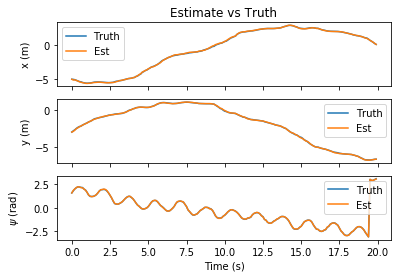

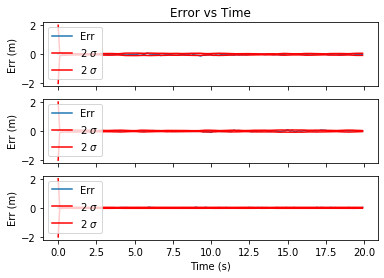

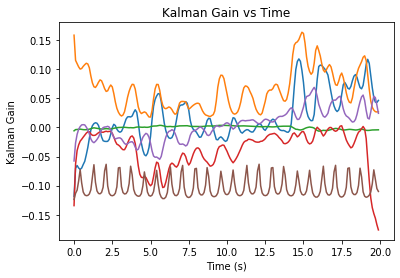

In [13]:
def generateVelocities(t):
    v = 1 + .5 * np.cos(2 * np.pi * 0.2 * t)
    w = -0.2 + 2 * np.cos(2 * np.pi * 0.6 * t)

    return v, w

def getMeasurements(state):
    z = np.zeros_like(params.lms, dtype=float)

    for i in range(z.shape[1]):
        lm = params.lms[:,i]
        ds = lm - state[0:2]

        r = np.sqrt(np.sum(ds**2))
        theta = np.arctan2(ds[1], ds[0]) - state[2]
        # theta = unwrap(theta) #not sure if this should be here or down a few lines

        z[0,i] = r + np.random.normal(0, params.sigma_r)
        z[1,i] = theta + np.random.normal(0, params.sigma_theta)
        z[1,i] = wrap(z[1,i])

    return z

#Generate time steps, commanded velocities and the actual velocities
t = np.arange(0, params.tf, params.dt)
vc, wc = generateVelocities(t)
v = vc + np.sqrt(params.alpha1 * vc**2 + params.alpha2 * wc**2) * np.random.randn(vc.size)
w = wc + np.sqrt(params.alpha3 * vc**2 + params.alpha4 * wc**2) * np.random.randn(wc.size)

#Initialize the EKF
ekf = EKF(params.dt)

#Keep histories for plotting purposes
x_hist = []
mu_hist = []
err_hist = []
x_covar_hist = []
y_covar_hist = []
psi_covar_hist = []
K_hist = []

x0 = params.x0
y0 = params.y0
phi0 = params.theta0
state = np.array([x0, y0, phi0])
dead_reckon = np.array([x0, y0, phi0])
mu = np.array([x0, y0, phi0])
Sigma = np.eye(3)

for i in range(t.size):
    #stuff for plotting
    x_hist.append(state)
    mu_hist.append(mu)
    err = state - mu
    err[2] = wrap(err[2])
    err_hist.append(err)
    x_covar_hist.append(Sigma[0,0])
    y_covar_hist.append(Sigma[1,1])
    psi_covar_hist.append(Sigma[2,2])

    state = ekf.propagateState(state, v[i], w[i])
    zt = getMeasurements(state)
    mu, Sigma, K = ekf.update(mu, zt, vc[i], wc[i])
    dead_reckon = ekf.propagateState(dead_reckon, vc[i], wc[i])

    K_hist.append(K)

fig1, ax1 = plt.subplots(nrows=3, ncols=1, sharex=True)
x_hist = np.array(x_hist).T
mu_hist = np.array(mu_hist).T
ax1[0].plot(t, x_hist[0,:], label="Truth")
ax1[0].plot(t, mu_hist[0,:], label="Est")
ax1[0].set_ylabel("x (m)")
ax1[0].legend()
ax1[1].plot(t, x_hist[1,:], label="Truth")
ax1[1].plot(t, mu_hist[1,:], label="Est")
ax1[1].set_ylabel("y (m)")
ax1[1].legend()
ax1[2].plot(t, x_hist[2,:], label="Truth")
ax1[2].plot(t, mu_hist[2,:], label="Est")
ax1[2].set_xlabel("Time (s)")
ax1[2].set_ylabel("$\psi$ (rad)")
ax1[2].legend()
ax1[0].set_title("Estimate vs Truth")

fig2, ax2 = plt.subplots(nrows=3, ncols=1, sharex=True)
err_hist = np.array(err_hist).T
x_err_bnd = np.sqrt(np.array(x_covar_hist)) * 2
y_err_bnd = np.sqrt(np.array(y_covar_hist)) * 2
psi_err_bnd = np.sqrt(np.array(psi_covar_hist)) * 2
ax2[0].plot(t, err_hist[0,:], label="Err")
ax2[0].plot(t, x_err_bnd, 'r', label="2 $\sigma$")
ax2[0].plot(t, -x_err_bnd, 'r', label="2 $\sigma$")
ax2[0].set_ylabel("Err (m)")
ax2[0].legend()
ax2[1].plot(t, err_hist[1,:], label="Err")
ax2[1].plot(t, y_err_bnd, 'r', label="2 $\sigma$")
ax2[1].plot(t, -y_err_bnd, 'r', label="2 $\sigma$")
ax2[1].set_ylabel("Err (m)")
ax2[1].legend()
ax2[2].plot(t, err_hist[2,:], label="Err")
ax2[2].plot(t, psi_err_bnd, 'r', label="2 $\sigma$")
ax2[2].plot(t, -psi_err_bnd, 'r', label="2 $\sigma$")
ax2[2].set_ylabel("Err (m)")
ax2[2].set_xlabel("Time (s)")
ax2[2].legend()
ax2[0].set_title("Error vs Time")

plt.figure(4)
K_hist = np.array(K_hist)
plt.plot(t, K_hist[:,0,0])
plt.plot(t, K_hist[:,1,0])
plt.plot(t, K_hist[:,2,0])
plt.plot(t, K_hist[:,0,1])
plt.plot(t, K_hist[:,1,1])
plt.plot(t, K_hist[:,2,1])
plt.xlabel("Time (s)")
plt.ylabel("Kalman Gain")
plt.title("Kalman Gain vs Time")